In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import math
from UnarySim.sw.kernel.exp_comb import expComb
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [4]:
def exp_comb_test(bw,mode="unipolar", rand_mode="Sobol"):
    
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = "cpu"
    rng = rand_mode
    col = 10000
    total_cnt = 100
    bitwidth = bw
    btype = torch.int8
    rtype=torch.float
    stype=torch.int8

    print("========================================================")
    print(mode)
    print("========================================================")
    # all input values are non-negative
    low_bound = 0
    if mode is "unipolar":
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        low_bound = 0
        up_bound = 2**(bitwidth-1)

    input_list = []
    for input_val in range(low_bound, up_bound+1, 1):
        input_list.append(input_val)
    
#     src = torch.ones(2**bitwidth)
#     for i in range(2**bitwidth):
#         src[i] = (i/2**bitwidth)
#         input = src.mul(2**bitwidth).round().div(2**bitwidth).to(device)
    input = torch.tensor(input_list).type(torch.float).div(up_bound).to(device)
    output = torch.exp(input.mul(-1))
    
#     output = torch.exp(input.mul(-1))
#     outputPE = ProgressiveError(output, mode=mode).to(device)
    
#     inputPE  = ProgressiveError(input,  mode=mode).to(device)
#     inputSRC = SourceGen(input, bitwidth, mode=mode, randtype=rtype)().to(device)
    
    result_pe_total = []
    for rand_idx in range(1, total_cnt+1):
        
        outputPE = ProgressiveError(output, mode=mode).to(device)
        inputPE  = ProgressiveError(input,  mode=mode).to(device)
        
        dut_exp_comb = expComb(mode,rng,1,bitwidth,rtype,stype, btype).to(device)
        inputSRC = SourceGen(input, bitwidth, mode=mode, rtype=rtype)().to(device)
        inputRNG = RNG(bitwidth, rand_idx, rng, rtype)().to(device)
        inputBS = BSGen(inputSRC, inputRNG, stype).to(device)
        with torch.no_grad():
            start_time = time.time()
            for i in range(2**bitwidth):
                input_bs = inputBS(torch.tensor([i]))
                inputPE.Monitor(input_bs)

                output_bs = dut_exp_comb(input_bs)
                outputPE.Monitor(output_bs)
        
        # get the result for different rng
        result_pe = outputPE()[1].cpu().numpy()
#         print("before append: ",result_pe)
        result_pe_total.append(result_pe)
#         print("after: ",result_pe_total)
        
    
    # get the result for different rng
    result_pe_total = np.array(result_pe_total)
    #######################################################################
    # check the error of all simulation
    #######################################################################
    print("RMSE:{:1.4}".format(math.sqrt(np.mean(result_pe_total**2))))
    print("MAE: {:1.4}".format(np.mean(np.abs(result_pe_total))))
    print("bias:{:1.4}".format(np.mean(result_pe_total)))
    print("max: {:1.4}".format(np.max(result_pe_total)))
    print("min: {:1.4}".format(np.min(result_pe_total)))

    #######################################################################
    # check the error according to input value
    #######################################################################
    max_total = np.max(result_pe_total, axis=0)
    min_total = np.min(result_pe_total, axis=0)
    avg_total = np.mean(result_pe_total, axis=0)
    
    axis_len = outputPE()[1].size()[0]
    input_x_axis = []
    for axis_index in range(axis_len):
        input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
    fig, ax = plt.subplots()
    ax.fill_between(input_x_axis, max_total, avg_total, facecolor="red", alpha=0.75)
    ax.fill_between(input_x_axis, avg_total, min_total, facecolor="blue", alpha=0.75)
    ax.plot(input_x_axis, avg_total, label='Avg error', color="black", linewidth=0.3)
    plt.tight_layout()
    plt.xlabel('Input value')
    plt.ylabel('Output error')
    plt.xticks(np.arange(0, 1.1, step=0.5))
    # ax.xaxis.set_ticklabels([])
    plt.xlim(0, 1)
    plt.yticks(np.arange(-0.2, 0.4, step=0.2))
    # ax.yaxis.set_ticklabels([])
    plt.ylim(-0.3, 0.55)
    plt.grid(b=True, which="both", axis="y", linestyle="--", color="grey", linewidth=0.3)
    fig.set_size_inches(4, 4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    plt.close()

unipolar
RMSE:0.02589
MAE: 0.01695
bias:-0.01524
max: 0.03565
min: -0.1053


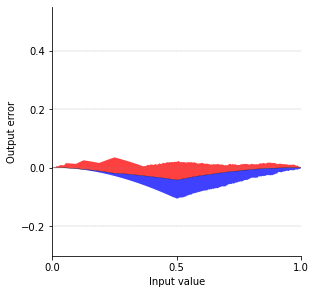

In [55]:
exp_comb_test(10,"unipolar", "Sobol")

unipolar
RMSE:0.01804
MAE: 0.01563
bias:0.01482
max: 0.05035
min: -0.02315


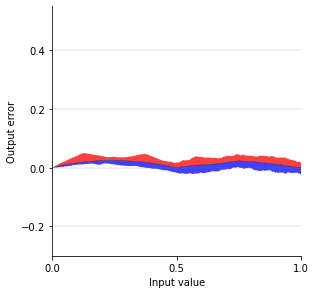

In [58]:
exp_comb_test(10,"unipolar", "LFSR")

unipolar
RMSE:0.02391
MAE: 0.01661
bias:-0.007926
max: 0.0453
min: -0.1011


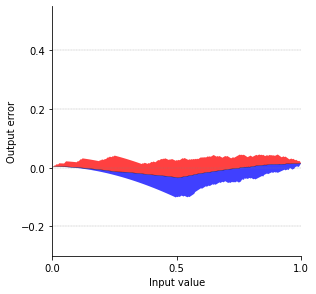

In [5]:
exp_comb_test(8,"unipolar", "Sobol")

unipolar
RMSE:0.01556
MAE: 0.01163
bias:0.005956
max: 0.0722
min: -0.05561


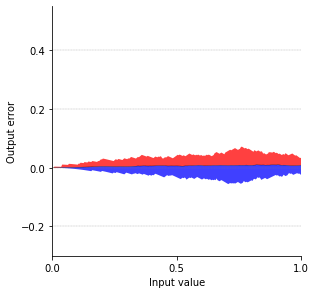

In [108]:
exp_comb_test(8,"unipolar", "SYS")